In [1]:
!nvidia-smi

Sat Sep 13 23:52:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [25]:
# --- 0. MONTAR GOOGLE DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# --- 1. IMPORTAR LIBRERÍAS PYTORCH ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [27]:
# --- 2. CONFIGURACIÓN ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

data_dir = '/content/drive/MyDrive/Colab Notebooks/train'
img_size = 224
batch_size = 32
num_epochs = 50

Usando dispositivo: cuda


In [28]:
# --- 3. TRANSFORMACIONES Y AUMENTO DE DATOS ---
# Transformaciones de entrenamiento (con data augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Transformaciones de validación (sin data augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [29]:
# --- 4. CARGAR DATOS ---
train_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=val_transform
)
# Dividir en train/validation (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(123)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = train_dataset.dataset.classes
print("Clases encontradas:", class_names)


Clases encontradas: ['ALPACA', 'LLAMA']


In [30]:
# --- 5. CONSTRUIR MODELO RESNET152 ---
class CustomResNet152(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomResNet152, self).__init__()
        self.base_model = models.resnet152(pretrained=True)

        # Congelar todos los parámetros inicialmente
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Reemplazar la última capa fully connected
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

    def unfreeze_layers(self, num_layers=50):
        """Descongelar las últimas capas para fine-tuning"""
        # Descongelar todas las capas para fine-tuning
        for param in self.base_model.parameters():
            param.requires_grad = True

model = CustomResNet152().to(device)
print("Modelo creado")

Modelo creado


In [31]:
# --- 6. FUNCIÓN DE ENTRENAMIENTO ---
def train_model(model, train_loader, val_loader, num_epochs, lr=0.001, fine_tune=False):
    criterion = nn.BCELoss()

    if fine_tune:
        optimizer = optim.Adam(model.parameters(), lr=lr/10)
        print("Iniciando fine-tuning...")
    else:
        # Solo optimizar la última capa inicialmente
        optimizer = optim.Adam(model.base_model.fc.parameters(), lr=lr)
        print("Entrenando solo la cabeza...")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_acc = 0.0

    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Guardar mejor modelo
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/best_model.pth')

    return train_losses, val_losses, train_accs, val_accs

In [32]:
# --- 7. ENTRENAMIENTO EN DOS FASES ---
# Fase 1: Solo la cabeza
print("=== FASE 1: ENTRENANDO SOLO LA CABEZA ===")
train_losses1, val_losses1, train_accs1, val_accs1 = train_model(
    model, train_loader, val_loader, num_epochs//2, lr=0.001, fine_tune=False
)

# Fase 2: Fine-tuning
print("=== FASE 2: FINE-TUNING ===")
model.unfreeze_layers()
train_losses2, val_losses2, train_accs2, val_accs2 = train_model(
    model, train_loader, val_loader, num_epochs//2, lr=0.0001, fine_tune=True
)

# Combinar resultados
train_losses = train_losses1 + train_losses2
val_losses = val_losses1 + val_losses2
train_accs = train_accs1 + train_accs2
val_accs = val_accs1 + val_accs2

=== FASE 1: ENTRENANDO SOLO LA CABEZA ===
Entrenando solo la cabeza...


Epoch 1/25: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch 1/25:
Train Loss: 0.7106, Train Acc: 50.67%
Val Loss: 0.6497, Val Acc: 58.93%


Epoch 2/25: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


Epoch 2/25:
Train Loss: 0.6870, Train Acc: 57.08%
Val Loss: 0.6279, Val Acc: 64.29%


Epoch 3/25: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]


Epoch 3/25:
Train Loss: 0.6571, Train Acc: 59.17%
Val Loss: 0.6055, Val Acc: 61.31%


Epoch 4/25: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]


Epoch 4/25:
Train Loss: 0.6182, Train Acc: 66.32%
Val Loss: 0.5900, Val Acc: 70.83%


Epoch 5/25: 100%|██████████| 21/21 [00:04<00:00,  4.66it/s]


Epoch 5/25:
Train Loss: 0.6241, Train Acc: 64.53%
Val Loss: 0.5682, Val Acc: 72.02%


Epoch 6/25: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


Epoch 6/25:
Train Loss: 0.6007, Train Acc: 67.66%
Val Loss: 0.5549, Val Acc: 71.43%


Epoch 7/25: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Epoch 7/25:
Train Loss: 0.5981, Train Acc: 68.41%
Val Loss: 0.5660, Val Acc: 73.21%


Epoch 8/25: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Epoch 8/25:
Train Loss: 0.6039, Train Acc: 66.92%
Val Loss: 0.6053, Val Acc: 69.05%


Epoch 9/25: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Epoch 9/25:
Train Loss: 0.5996, Train Acc: 68.70%
Val Loss: 0.5857, Val Acc: 69.05%


Epoch 10/25: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Epoch 10/25:
Train Loss: 0.6217, Train Acc: 65.57%
Val Loss: 0.5739, Val Acc: 72.02%


Epoch 11/25: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]


Epoch 11/25:
Train Loss: 0.6031, Train Acc: 67.36%
Val Loss: 0.6070, Val Acc: 67.26%


Epoch 12/25: 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Epoch 12/25:
Train Loss: 0.6035, Train Acc: 69.60%
Val Loss: 0.5741, Val Acc: 75.60%


Epoch 13/25: 100%|██████████| 21/21 [00:05<00:00,  4.20it/s]


Epoch 13/25:
Train Loss: 0.5646, Train Acc: 71.68%
Val Loss: 0.5813, Val Acc: 72.02%


Epoch 14/25: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]


Epoch 14/25:
Train Loss: 0.5768, Train Acc: 70.04%
Val Loss: 0.6044, Val Acc: 67.86%


Epoch 15/25: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]


Epoch 15/25:
Train Loss: 0.5696, Train Acc: 72.58%
Val Loss: 0.5822, Val Acc: 69.05%


Epoch 16/25: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]


Epoch 16/25:
Train Loss: 0.5908, Train Acc: 68.85%
Val Loss: 0.5752, Val Acc: 68.45%


Epoch 17/25: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


Epoch 17/25:
Train Loss: 0.5907, Train Acc: 68.11%
Val Loss: 0.5901, Val Acc: 69.05%


Epoch 18/25: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Epoch 18/25:
Train Loss: 0.5795, Train Acc: 69.90%
Val Loss: 0.5601, Val Acc: 72.02%


Epoch 19/25: 100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


Epoch 19/25:
Train Loss: 0.5636, Train Acc: 73.62%
Val Loss: 0.5488, Val Acc: 74.40%


Epoch 20/25: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]


Epoch 20/25:
Train Loss: 0.5608, Train Acc: 70.49%
Val Loss: 0.5106, Val Acc: 76.79%


Epoch 21/25: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]


Epoch 21/25:
Train Loss: 0.5614, Train Acc: 73.03%
Val Loss: 0.5604, Val Acc: 72.02%


Epoch 22/25: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Epoch 22/25:
Train Loss: 0.5927, Train Acc: 66.17%
Val Loss: 0.5723, Val Acc: 70.83%


Epoch 23/25: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Epoch 23/25:
Train Loss: 0.5834, Train Acc: 69.75%
Val Loss: 0.5436, Val Acc: 73.81%


Epoch 24/25: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]


Epoch 24/25:
Train Loss: 0.5696, Train Acc: 71.24%
Val Loss: 0.5162, Val Acc: 77.38%


Epoch 25/25: 100%|██████████| 21/21 [00:04<00:00,  4.24it/s]


Epoch 25/25:
Train Loss: 0.5717, Train Acc: 69.60%
Val Loss: 0.5316, Val Acc: 75.00%
=== FASE 2: FINE-TUNING ===
Iniciando fine-tuning...


Epoch 1/25: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]


Epoch 1/25:
Train Loss: 0.5609, Train Acc: 70.49%
Val Loss: 0.5142, Val Acc: 75.00%


Epoch 2/25: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


Epoch 2/25:
Train Loss: 0.5330, Train Acc: 73.92%
Val Loss: 0.4913, Val Acc: 79.17%


Epoch 3/25: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch 3/25:
Train Loss: 0.5091, Train Acc: 75.26%
Val Loss: 0.5402, Val Acc: 76.19%


Epoch 4/25: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Epoch 4/25:
Train Loss: 0.4569, Train Acc: 79.58%
Val Loss: 0.4506, Val Acc: 76.79%


Epoch 5/25: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


Epoch 5/25:
Train Loss: 0.4868, Train Acc: 75.11%
Val Loss: 0.4124, Val Acc: 83.33%


Epoch 6/25: 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]


Epoch 6/25:
Train Loss: 0.4314, Train Acc: 80.18%
Val Loss: 0.4847, Val Acc: 76.79%


Epoch 7/25: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Epoch 7/25:
Train Loss: 0.4207, Train Acc: 81.52%
Val Loss: 0.4689, Val Acc: 78.57%


Epoch 8/25: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


Epoch 8/25:
Train Loss: 0.4031, Train Acc: 82.12%
Val Loss: 0.4013, Val Acc: 79.17%


Epoch 9/25: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 9/25:
Train Loss: 0.3977, Train Acc: 81.22%
Val Loss: 0.3976, Val Acc: 83.33%


Epoch 10/25: 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]


Epoch 10/25:
Train Loss: 0.3904, Train Acc: 83.01%
Val Loss: 0.4703, Val Acc: 79.76%


Epoch 11/25: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]


Epoch 11/25:
Train Loss: 0.3861, Train Acc: 80.92%
Val Loss: 0.4220, Val Acc: 84.52%


Epoch 12/25: 100%|██████████| 21/21 [00:04<00:00,  4.38it/s]


Epoch 12/25:
Train Loss: 0.3547, Train Acc: 86.14%
Val Loss: 0.4958, Val Acc: 82.74%


Epoch 13/25: 100%|██████████| 21/21 [00:04<00:00,  4.36it/s]


Epoch 13/25:
Train Loss: 0.3578, Train Acc: 83.61%
Val Loss: 0.3778, Val Acc: 86.90%


Epoch 14/25: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Epoch 14/25:
Train Loss: 0.3301, Train Acc: 85.10%
Val Loss: 0.4090, Val Acc: 83.33%


Epoch 15/25: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Epoch 15/25:
Train Loss: 0.3182, Train Acc: 87.48%
Val Loss: 0.3530, Val Acc: 81.55%


Epoch 16/25: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch 16/25:
Train Loss: 0.3155, Train Acc: 86.29%
Val Loss: 0.4225, Val Acc: 82.74%


Epoch 17/25: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]


Epoch 17/25:
Train Loss: 0.2945, Train Acc: 87.78%
Val Loss: 0.4257, Val Acc: 82.14%


Epoch 18/25: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


Epoch 18/25:
Train Loss: 0.2970, Train Acc: 88.08%
Val Loss: 0.4309, Val Acc: 86.90%


Epoch 19/25: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]


Epoch 19/25:
Train Loss: 0.2591, Train Acc: 89.72%
Val Loss: 0.4604, Val Acc: 84.52%


Epoch 20/25: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 20/25:
Train Loss: 0.2544, Train Acc: 90.16%
Val Loss: 0.4200, Val Acc: 84.52%


Epoch 21/25: 100%|██████████| 21/21 [00:04<00:00,  4.62it/s]


Epoch 21/25:
Train Loss: 0.2475, Train Acc: 90.16%
Val Loss: 0.3982, Val Acc: 82.14%


Epoch 22/25: 100%|██████████| 21/21 [00:04<00:00,  4.55it/s]


Epoch 22/25:
Train Loss: 0.2830, Train Acc: 88.08%
Val Loss: 0.4307, Val Acc: 83.93%


Epoch 23/25: 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


Epoch 23/25:
Train Loss: 0.2212, Train Acc: 91.65%
Val Loss: 0.3323, Val Acc: 86.90%


Epoch 24/25: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


Epoch 24/25:
Train Loss: 0.2456, Train Acc: 90.76%
Val Loss: 0.3831, Val Acc: 80.36%


Epoch 25/25: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]


Epoch 25/25:
Train Loss: 0.2171, Train Acc: 90.91%
Val Loss: 0.3862, Val Acc: 82.74%


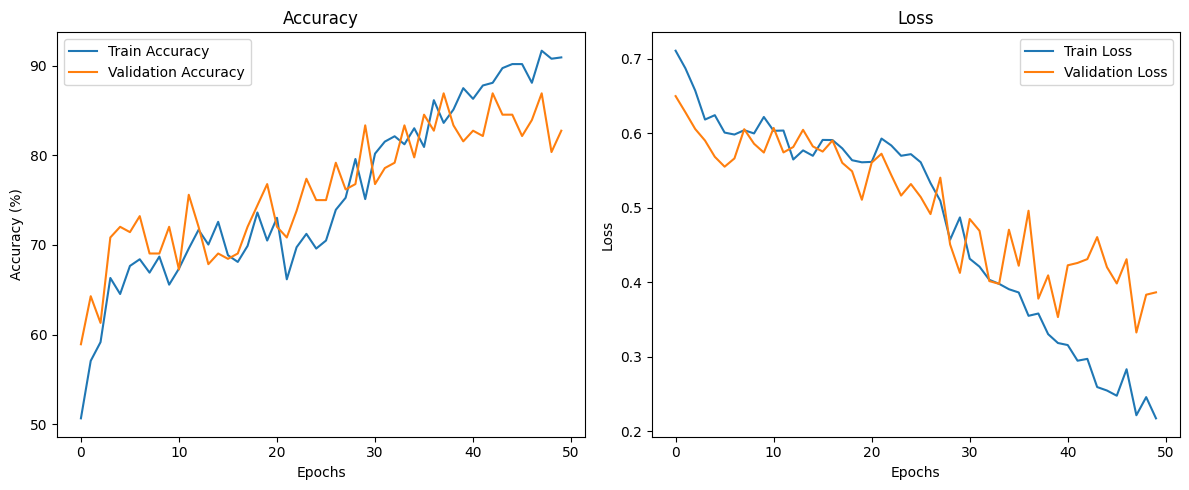

In [33]:
# --- 8. VISUALIZACIÓN ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/training_history.png')
plt.show()

In [34]:
# --- 9. GRAD-CAM EN PYTORCH ---
def compute_gradcam(model, img_tensor, target_layer):
    """
    Función Grad-CAM para PyTorch
    """
    activations = None
    gradients = None

    # Hook para capturar activaciones
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Hook para capturar gradientes
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    # Registrar hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.eval()
    output = model(img_tensor)
    pred_class = (output > 0.5).float().item()

    # Backward pass
    model.zero_grad()
    output.backward()

    # Remover hooks
    handle_forward.remove()
    handle_backward.remove()

    # Calcular heatmap
    if activations is not None and gradients is not None:
        weights = torch.mean(gradients, dim=(2, 3))[0]
        heatmap = torch.zeros(activations.shape[2:])

        for i, w in enumerate(weights):
            heatmap += w * activations[0, i]

        heatmap = torch.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy(), pred_class

    return None, pred_class

def show_gradcam(image, heatmap, alpha=0.6):
    """Mostrar imagen con heatmap superpuesto"""
    # Convertir heatmap a color
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convertir imagen tensor a numpy
    img = image.permute(1, 2, 0).numpy()
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Superponer heatmap
    superimposed = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    return superimposed

=== GENERANDO GRAD-CAM ===
Usando capa: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

Imagen 1:
Real: ALPACA, Pred: ALPACA (0.446)


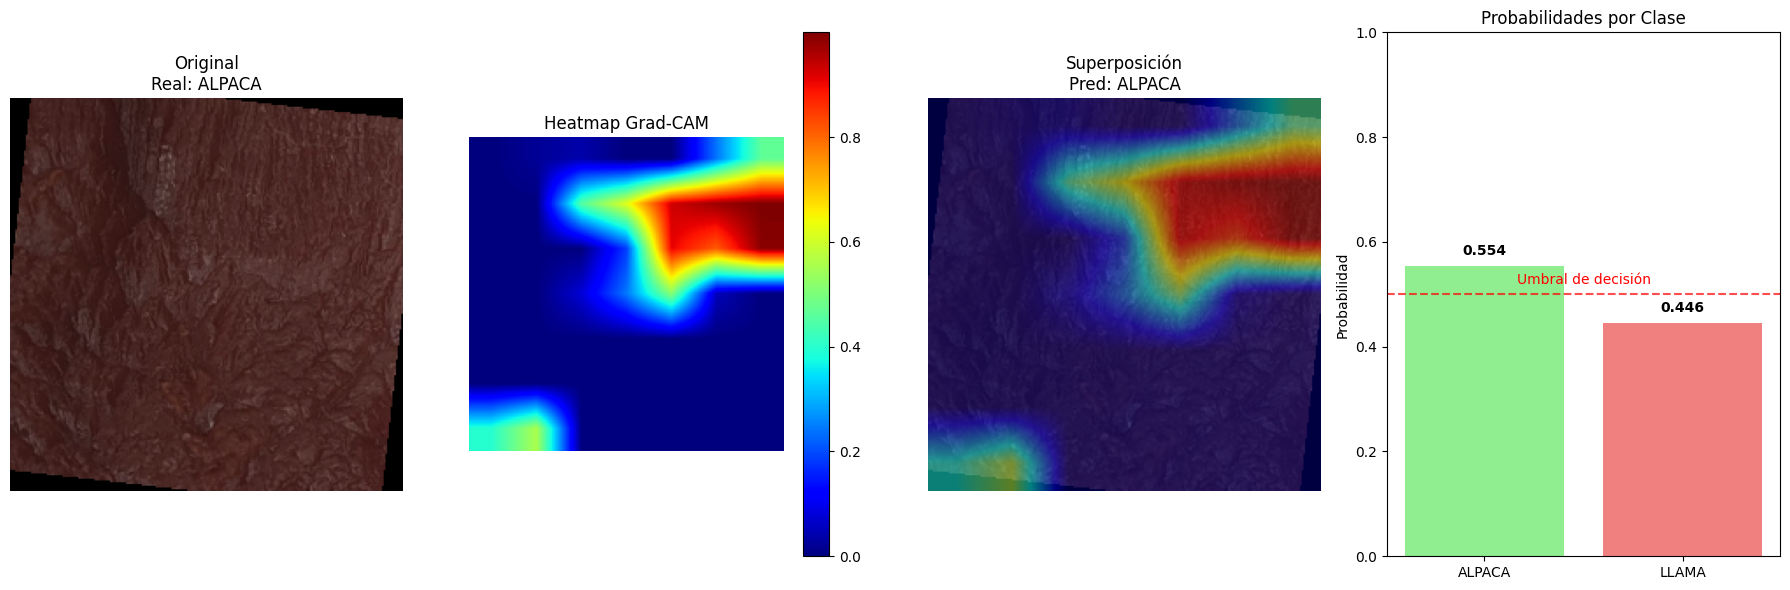

Probabilidades:
  P(ALPACA) = 0.554
  P(LLAMA) = 0.446
Predicción: ALPACA
Correcto: ✅
Confianza: 0.554
✅ PREDICCIÓN CORRECTA

Imagen 2:
Real: ALPACA, Pred: ALPACA (0.152)


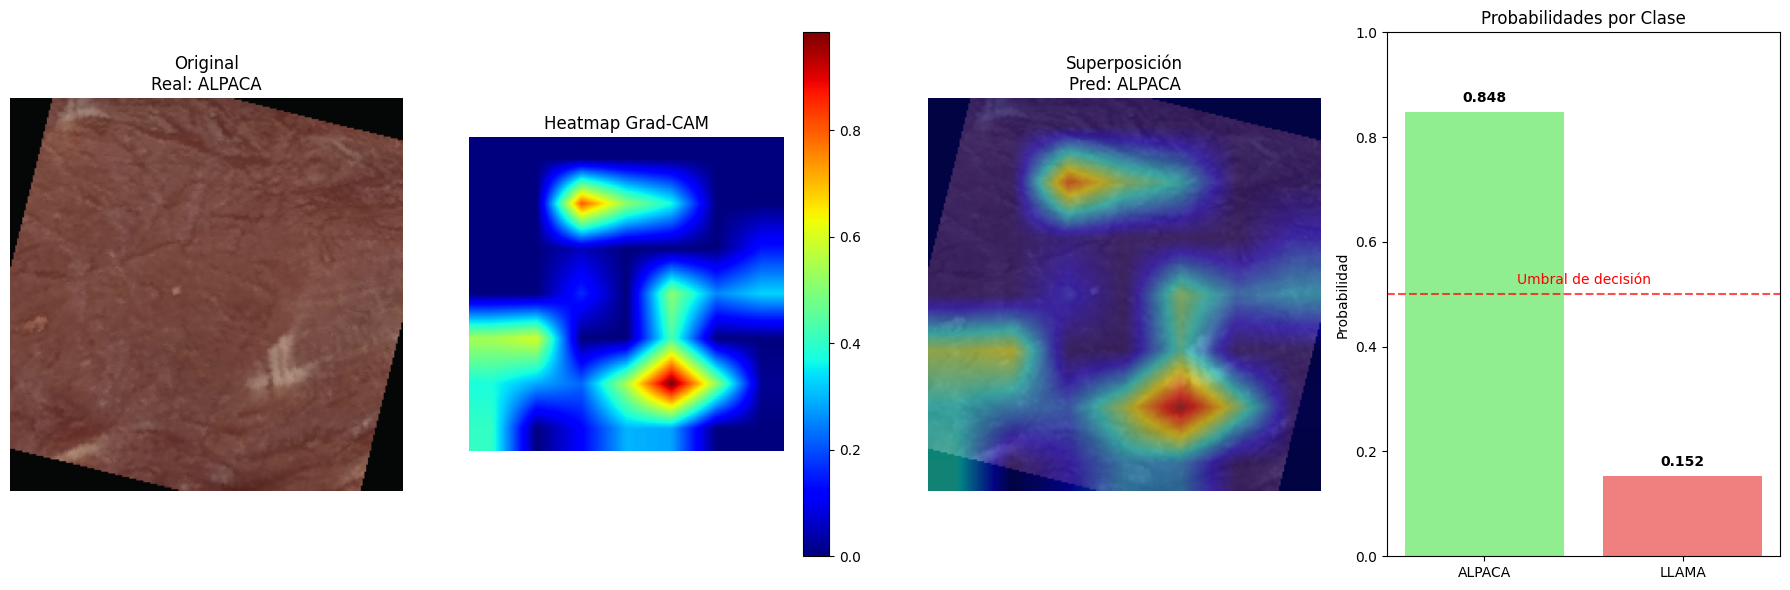

Probabilidades:
  P(ALPACA) = 0.848
  P(LLAMA) = 0.152
Predicción: ALPACA
Correcto: ✅
Confianza: 0.848
✅ PREDICCIÓN CORRECTA

Imagen 3:
Real: LLAMA, Pred: LLAMA (0.990)


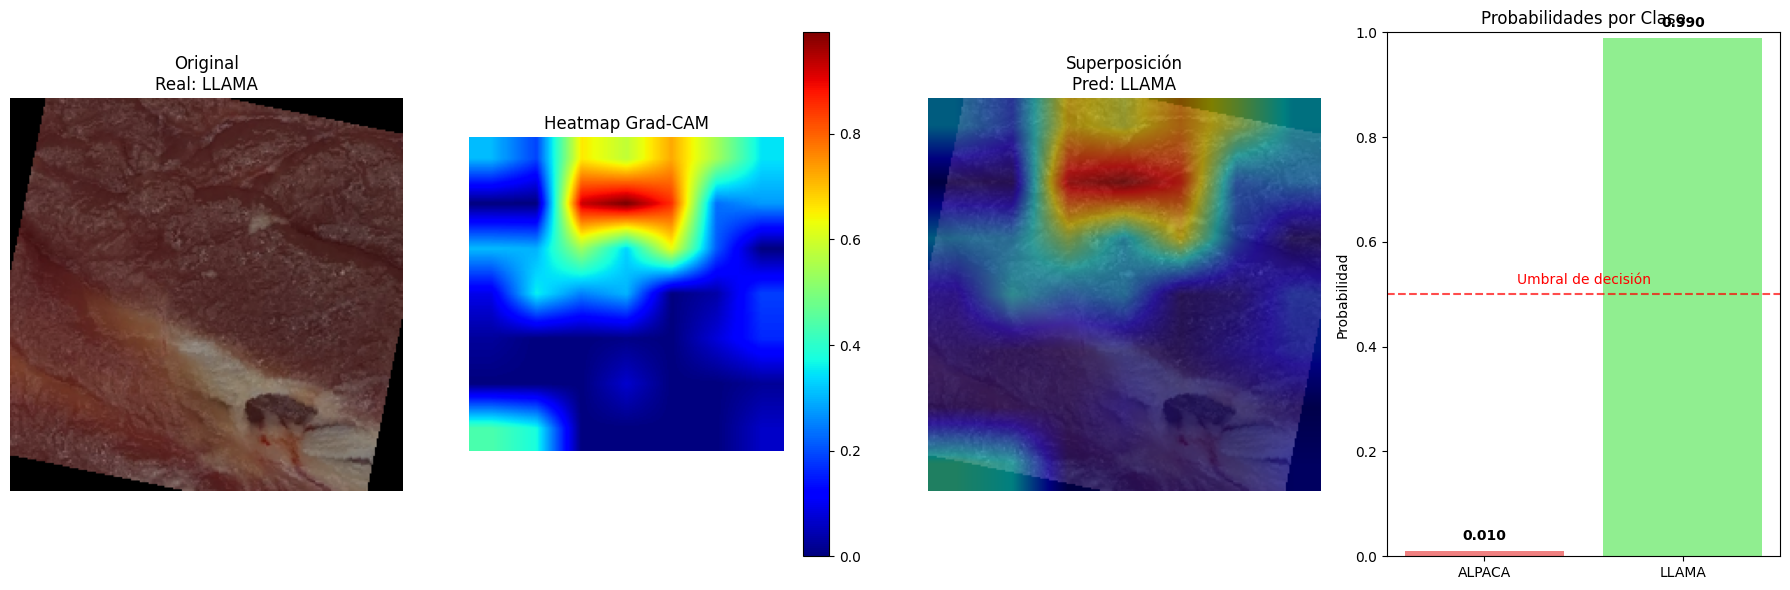

Probabilidades:
  P(ALPACA) = 0.010
  P(LLAMA) = 0.990
Predicción: LLAMA
Correcto: ✅
Confianza: 0.990
✅ PREDICCIÓN CORRECTA

Imagen 4:
Real: LLAMA, Pred: LLAMA (0.871)


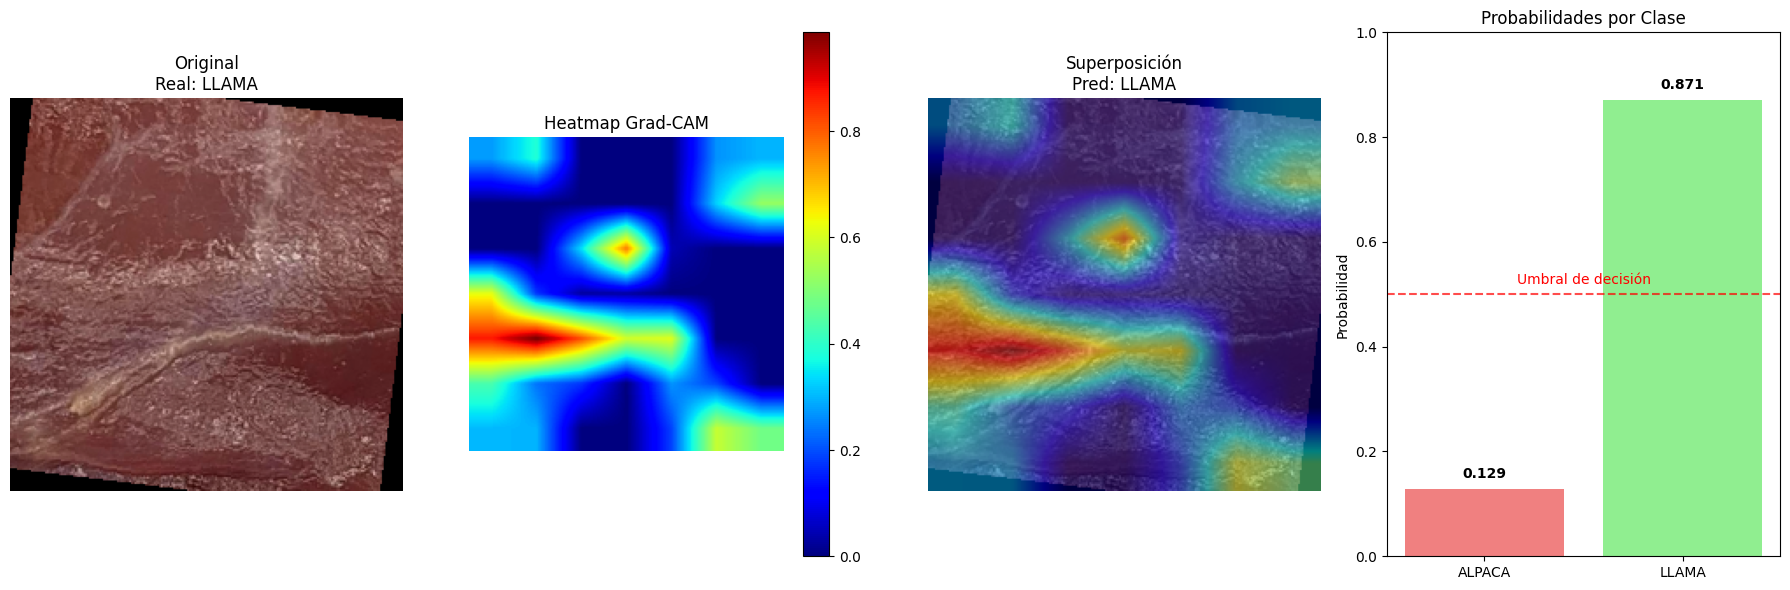

Probabilidades:
  P(ALPACA) = 0.129
  P(LLAMA) = 0.871
Predicción: LLAMA
Correcto: ✅
Confianza: 0.871
✅ PREDICCIÓN CORRECTA


In [43]:
# --- 10. EJECUTAR GRAD-CAM ---
print("=== GENERANDO GRAD-CAM ===")

# Cargar mejor modelo
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/best_model.pth'))

# Encontrar capa objetivo
target_layer = None
for name, module in model.base_model.named_modules():
    if isinstance(module, nn.Conv2d) and "layer4.2.conv3" in name:
        target_layer = module
        break

if target_layer is None:
    for name, module in model.base_model.named_modules():
        if isinstance(module, nn.Conv2d) and "layer4" in name:
            target_layer = module
            break

if target_layer:
    print(f"Usando capa: {target_layer}")

    # Procesar imágenes de ambas clases
    num_images_per_class = 2
    count_alpaca = 0
    count_llama = 0

    for images, labels in val_loader:
        for i in range(len(images)):
            if count_alpaca >= num_images_per_class and count_llama >= num_images_per_class:
                break

            img_tensor = images[i].unsqueeze(0).to(device)
            true_label = labels[i].item()

            # Solo procesar si necesitamos más de esta clase
            if true_label == 0 and count_alpaca >= num_images_per_class:
                continue
            if true_label == 1 and count_llama >= num_images_per_class:
                continue

            # Predicción sin gradientes
            with torch.no_grad():
                model.eval()
                output = model(img_tensor)
                pred_prob = output.item()
                pred_class = 1 if pred_prob > 0.5 else 0

            print(f"\nImagen {count_alpaca + count_llama + 1}:")
            print(f"Real: {class_names[true_label]}, Pred: {class_names[pred_class]} ({pred_prob:.3f})")

            # --- GRAD-CAM ---
            def compute_gradcam(model, img_tensor, target_layer):
                activations = []
                gradients = []

                def forward_hook(module, input, output):
                    activations.append(output)

                def backward_hook(module, grad_input, grad_output):
                    gradients.append(grad_output[0])

                forward_handle = target_layer.register_forward_hook(forward_hook)
                backward_handle = target_layer.register_full_backward_hook(backward_hook)

                model.train()
                img_tensor.requires_grad_(True)

                output = model(img_tensor)
                pred_class = (output > 0.5).float().item()

                model.zero_grad()
                target = torch.tensor([pred_class], dtype=torch.float32, device=device).unsqueeze(0)
                loss = nn.BCELoss()(output, target)
                loss.backward()

                forward_handle.remove()
                backward_handle.remove()
                model.eval()

                if activations and gradients:
                    activations = activations[0].detach().cpu()
                    gradients = gradients[0].detach().cpu()

                    weights = torch.mean(gradients, dim=(2, 3))[0]
                    heatmap = torch.zeros(activations.shape[2:])

                    for j, w in enumerate(weights):
                        heatmap += w * activations[0, j]

                    heatmap = torch.relu(heatmap)
                    if torch.max(heatmap) > 0:
                        heatmap /= torch.max(heatmap)

                    return heatmap.numpy()

                return None

            # Calcular heatmap
            heatmap = compute_gradcam(model, img_tensor, target_layer)

            if heatmap is not None:
                # --- VISUALIZACIÓN ---
                def visualize_gradcam(image_tensor, heatmap, alpha=0.5, true_label=None, pred_prob=None, class_names=None):
                    # Imagen original
                    img = image_tensor.cpu().numpy()
                    img = np.transpose(img, (1, 2, 0))
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img = np.clip(img, 0, 1)

                    # Heatmap
                    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
                    heatmap_uint8 = np.uint8(255 * heatmap_resized)
                    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
                    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
                    heatmap_color = heatmap_color.astype(np.float32) / 255.0

                    # Superposición
                    superimposed = img * (1 - alpha) + heatmap_color * alpha
                    superimposed = np.clip(superimposed, 0, 1)

                    # Probabilidades
                    prob_alpaca = 1 - pred_prob
                    prob_llama = pred_prob

                    # Colores según corrección
                    if true_label == 0:
                        colors = ['lightgreen', 'lightcoral'] if pred_prob < 0.5 else ['lightcoral', 'lightgreen']
                    else:
                        colors = ['lightcoral', 'lightgreen'] if pred_prob > 0.5 else ['lightgreen', 'lightcoral']

                    return img, heatmap_resized, superimposed, prob_alpaca, prob_llama, colors

                # Obtener visualizaciones
                original_img, heatmap_img, superimposed_img, prob_alpaca, prob_llama, colors = visualize_gradcam(
                    images[i], heatmap, true_label=true_label, pred_prob=pred_prob, class_names=class_names
                )

                # Mostrar resultados
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 4, 1)
                plt.imshow(original_img)
                plt.title(f'Original\nReal: {class_names[true_label]}', fontsize=12)
                plt.axis('off')

                plt.subplot(1, 4, 2)
                plt.imshow(heatmap_img, cmap='jet')
                plt.title('Heatmap Grad-CAM', fontsize=12)
                plt.axis('off')
                plt.colorbar()

                plt.subplot(1, 4, 3)
                plt.imshow(superimposed_img)
                plt.title(f'Superposición\nPred: {class_names[pred_class]}', fontsize=12)
                plt.axis('off')

                plt.subplot(1, 4, 4)
                classes = class_names
                prob_values = [prob_alpaca, prob_llama]

                plt.bar(classes, prob_values, color=colors)
                plt.title('Probabilidades por Clase', fontsize=12)
                plt.ylabel('Probabilidad')
                plt.ylim(0, 1)

                for j, v in enumerate(prob_values):
                    plt.text(j, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

                plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
                plt.text(0.5, 0.52, 'Umbral de decisión', color='red', ha='center')

                plt.tight_layout()
                plt.show()

                # Información
                print(f"Probabilidades:")
                print(f"  P(ALPACA) = {prob_alpaca:.3f}")
                print(f"  P(LLAMA) = {prob_llama:.3f}")
                print(f"Predicción: {class_names[pred_class]}")
                print(f"Correcto: {'✅' if pred_class == true_label else '❌'}")

                confianza = max(prob_alpaca, prob_llama)
                print(f"Confianza: {confianza:.3f}")

                if pred_class == true_label:
                    print("✅ PREDICCIÓN CORRECTA")
                else:
                    print("❌ ERROR DE PREDICCIÓN")

            # Contar por clase
            if true_label == 0:
                count_alpaca += 1
            else:
                count_llama += 1

        if count_alpaca >= num_images_per_class and count_llama >= num_images_per_class:
            break

=== GENERANDO MATRIZ DE CONFUSIÓN ===


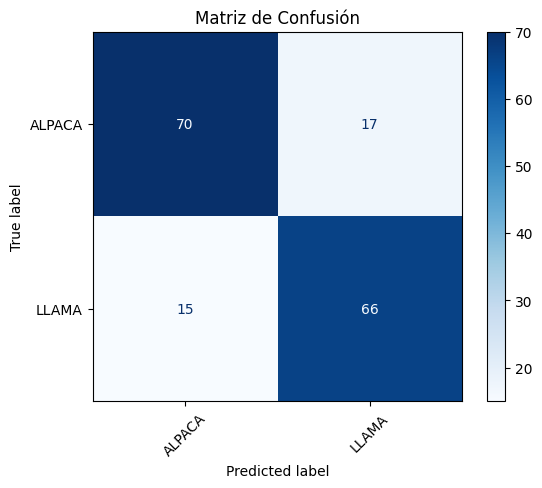

Accuracy final: 0.810
Predicciones: [1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]...
Labels reales: [0 0 0 0 0 1 0 0 0 0]...


In [42]:
# --- 11. MATRIZ DE CONFUSIÓN (esto SÍ funciona) ---
print("=== GENERANDO MATRIZ DE CONFUSIÓN ===")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())

# Convertir a arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.xticks(rotation=45)
plt.show()

# Métricas
accuracy = (all_preds == all_labels).mean()
print(f"Accuracy final: {accuracy:.3f}")
print(f"Predicciones: {all_preds[:10]}...")
print(f"Labels reales: {all_labels[:10]}...")

In [ ]:
# --- 12. GUARDAR MODELO FINAL ---
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'accuracy': accuracy
}, '/content/drive/MyDrive/Colab Notebooks/final_model_complete.pth')

print("✅ ¡Entrenamiento completado exitosamente!")